Step 47999 @ Episode 2000/2000
Training done.


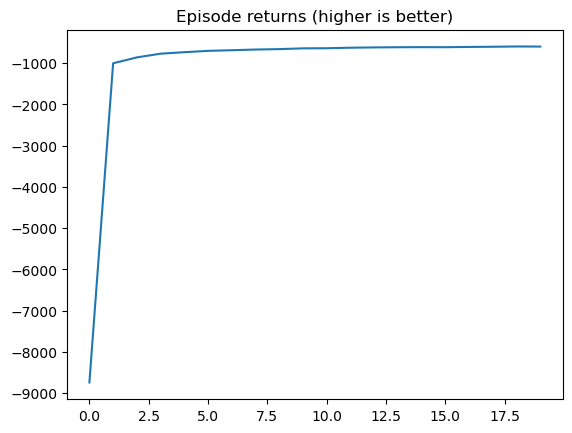


Heure | Pin  | Pgo  | PV   | Pch | Pdis | Ebat | S
    0 | 5.50 | 0.00 | 0.00 | 0.00 | 1.50 | 2.50 | 1
    1 | 5.50 | 0.00 | 0.00 | 0.00 | 1.50 | 1.00 | 1
    2 | 6.00 | 0.00 | 0.00 | 0.00 | 1.00 | 0.00 | 1
    3 | 5.50 | 0.00 | 0.00 | 1.50 | 0.00 | 1.50 | 0
    4 | 5.50 | 0.00 | 0.00 | 1.50 | 0.00 | 3.00 | 0
    5 | 7.00 | 0.00 | 0.00 | 0.00 | 0.00 | 3.00 | 1
    6 | 7.00 | 0.00 | 0.00 | 0.00 | 0.00 | 3.00 | 1
    7 | 7.00 | 0.00 | 0.00 | 0.00 | 0.00 | 3.00 | 1
    8 | 6.00 | 0.00 | 1.00 | 0.00 | 0.00 | 3.00 | 1
    9 | 6.50 | 0.00 | 2.00 | 1.50 | 0.00 | 4.50 | 1
   10 | 5.50 | 0.00 | 3.00 | 1.50 | 0.00 | 6.00 | 1
   11 | 4.50 | 0.00 | 4.00 | 1.50 | 0.00 | 7.50 | 1
   12 | 3.50 | 0.00 | 5.00 | 1.50 | 0.00 | 9.00 | 1
   13 | 1.50 | 0.00 | 4.00 | 0.00 | 1.50 | 7.50 | 1
   14 | 2.50 | 0.00 | 3.00 | 1.50 | 0.00 | 9.00 | 0
   15 | 5.00 | 0.00 | 2.00 | 0.00 | 0.00 | 9.00 | 1
   16 | 4.50 | 0.00 | 1.00 | 0.00 | 1.50 | 7.50 | 1
   17 | 5.50 | 0.00 | 0.00 | 1.50 | 0.00 | 9.00 | 0
   18 | 5.50

In [ ]:
import numpy as np
import random
import sys
import matplotlib.pyplot as plt

N = 24
T = range(N)

C_grid_buy  = [0.12 if (h < 8 or h >= 20) else 0.20 for h in T]
C_grid_sell = [0.12 for _ in T]

C_L   = 4
C_bat = 0.1
C_emissions_grid = 1.0
C_emissions_PV   = 0.02

P_fixed = [4.0 for _ in T]
P_flex  = [3.0 for _ in T]

PV_max = []
for h in T:
    if 6 <= h <= 18:
        PV_max.append(max(0.0, 5.0 - abs(h - 12)))
    else:
        PV_max.append(0.0)

P_g_max_import = 7.0
P_g_max_export = 4.0

E_bat_max  = 10.0
P_bat_max  = 1.5
E_bat_init = 4.0

BIG_UNMET_PENALTY = 1000.0  # pénalité très forte si non-servi (si import max atteint)


# Discrétisation -> 400 états = 2 (prix) * 20 (SOC) * 10 (PV)
SOC_BINS = 20          # 0..19
PV_BINS  = 10          # 0..9
PRICE_BINS = 2         # offpeak/peak
N_STATES = PRICE_BINS * SOC_BINS * PV_BINS

def price_bin(t):
    # offpeak: h < 8 ou h >= 20 
    return 0 if (t < 8 or t >= 20) else 1

def soc_bin(E):
    b = int(np.floor(E / 0.5))
    return max(0, min(SOC_BINS - 1, b))

def pv_bin(pv):
    b = int(np.floor(pv / 0.5))
    return max(0, min(PV_BINS - 1, b))

def state_index(t, E):
    pb = price_bin(t)
    sb = soc_bin(E)
    vb = pv_bin(PV_max[t])
    return (pb * SOC_BINS * PV_BINS) + (sb * PV_BINS) + vb


# Actions 
# battery_mode
# S in {0:OFF,1:ON}
# a = 3*S + battery_mode  -> 0..5
N_ACTIONS = 6

def decode_action(a):
    battery_mode = a % 3 # 0,1,2
    S = a // 3 # 0,1
    return battery_mode, S


class SmartBuildingEMS:
    def __init__(self):
        self.reset()

    def reset(self):
        self.t = 0
        self.E = E_bat_init
        s = state_index(self.t, self.E)
        return s, {}

    def step(self, a):
        battery_mode, S = decode_action(a)

        # choix batterie
        Pch  = P_bat_max if battery_mode == 0 else 0.0
        Pdis = P_bat_max if battery_mode == 2 else 0.0

        # contraintes énergie batterie
        Pdis = min(Pdis, self.E)
        Pch  = min(Pch,  E_bat_max - self.E)

        # profils exogènes
        pv_av = PV_max[self.t]
        load  = P_fixed[self.t] + S * P_flex[self.t] + Pch

        # on utilise le PV 
        PV_used = pv_av
        supply  = PV_used + Pdis

        net = supply - load  # >0 surplus, <0 deficit

        Pin = 0.0
        Pgo = 0.0
        unmet = 0.0

        if net >= 0:
            # export limité
            Pgo = min(net, P_g_max_export)
            excess = net - Pgo

            # curtail PV si trop de surplus 
            if excess > 0:
                curt = min(PV_used, excess)
                PV_used -= curt
                excess -= curt

            # si encore excess, on réduit la décharge
            if excess > 0:
                red = min(Pdis, excess)
                Pdis -= red
                excess -= red

            # recompute export 
            supply2 = PV_used + Pdis
            net2 = supply2 - load
            Pgo = min(max(0.0, net2), P_g_max_export)

        else:
            deficit = -net
            Pin = min(deficit, P_g_max_import)
            unmet = max(0.0, deficit - Pin)

        # update SOC
        E_next = self.E + Pch - Pdis
        E_next = max(0.0, min(E_bat_max, E_next))

        # coût (reward = -coût)
        step_cost  = (C_grid_buy[self.t] + C_emissions_grid) * Pin
        step_cost += - C_grid_sell[self.t] * Pgo
        step_cost += C_emissions_PV * PV_used
        step_cost += C_L * P_flex[self.t] * (1 - S)
        step_cost += - C_bat * E_next
        step_cost += BIG_UNMET_PENALTY * unmet

        r = -step_cost  # Q-learning => on maximise

        # avance temps
        self.t += 1
        self.E = E_next

        terminated = (self.t >= N)
        s_next = None if terminated else state_index(self.t, self.E)

        info = dict(t=self.t-1, Pin=Pin, Pgo=Pgo, PV=PV_used, Pch=Pch, Pdis=Pdis, Ebat=E_next, S=S, unmet=unmet)
        return s_next, r, terminated, False, info


# Q-learning
# w a taille N_STATES * N_ACTIONS
# q(s,a,w) = w[idx(s,a)]
# phi(s,a) = one-hot 
def idx_sa(s, a):
    return s * N_ACTIONS + a

def q(s, a, w):
    return w[idx_sa(s, a)]

def draw_action_greedy_policy(s, w, eps):
    if random.random() < eps:
        return random.randrange(N_ACTIONS)
    qs = [q(s, a, w) for a in range(N_ACTIONS)]
    best = np.max(qs)
    best_as = [a for a, val in enumerate(qs) if abs(val - best) < 1e-12]
    return random.choice(best_as)


# Entraînement
env = SmartBuildingEMS()

episode_lengths = []
episode_returns = []
episode_returns_aver = []

n_episodes = 2000
alpha = 0.05
gamma = 0.99
eps = 0.1

w = np.zeros(N_STATES * N_ACTIONS)
k = 0

for episode in range(n_episodes):
    sys.stdout.flush()
    s = env.reset()[0]
    terminated = False

    episode_lengths.append(0)
    G = 0.0

    while not terminated:
        a = draw_action_greedy_policy(s, w, eps)
        s_, r, terminated, truncated, info = env.step(a)

        episode_lengths[-1] += 1
        G += r

        # max_a' q(s',a')
        if terminated:
            target = r
        else:
            target = r + gamma * max(q(s_, ap, w) for ap in range(N_ACTIONS))

        td = target - q(s, a, w)
        w[idx_sa(s, a)] += alpha * td

        s = s_
        print(f"\rStep {k} @ Episode {episode+1}/{n_episodes}", end="")
        k += 1
    episode_returns_aver.append(G)
    if episode%100 == 0:
        aver = np.mean(episode_returns_aver)
        episode_returns.append(aver)

print("\nTraining done.")

plt.figure()
plt.plot(episode_returns)
plt.title("Episode returns (higher is better)")
plt.show()


# Exécution greedy (eps=0) + RESULTAT COMME CPLEX
env2 = SmartBuildingEMS()
s = env2.reset()[0]
terminated = False
dispatch = []

while not terminated:
    a = draw_action_greedy_policy(s, w, eps=0.0)
    s, r, terminated, _, info = env2.step(a)
    dispatch.append(info)

print("\nHeure | Pin  | Pgo  | PV   | Pch | Pdis | Ebat | S")
for info in dispatch:
    t = info["t"]
    print(f"{t:5d} | "
          f"{info['Pin']:4.2f} | "
          f"{info['Pgo']:4.2f} | "
          f"{info['PV']:4.2f} | "
          f"{info['Pch']:4.2f} | "
          f"{info['Pdis']:4.2f} | "
          f"{info['Ebat']:4.2f} | "
          f"{int(round(info['S']))}")
